## **Transfer Learning using Feature Extraction Method -- Without Data Augmentation**

Transfer learning is a machine learning ***`technique that allows a model trained on one task to be reused or adapted for a different task`***. There are two main types of transfer learning:

* ***`Feature Extraction:`*** In feature extraction, a pre-trained model is used as a fixed feature extractor. The pre-trained model is typically trained on a large dataset, such as ImageNet, and the final layer(s) that output the class predictions are removed. The remaining layers are then used as a feature extractor for a new dataset. These extracted features can be used as input to train a new model on the new dataset.

* ***`Fine-tuning:`*** In fine-tuning, a pre-trained model is used as an initialization for a new model. The pre-trained model is typically trained on a large dataset, such as ImageNet, and the final layer(s) that output the class predictions are replaced with new ones for the new task. The new model is then trained on the new dataset while keeping the weights of the pre-trained layers fixed or with a small learning rate. 




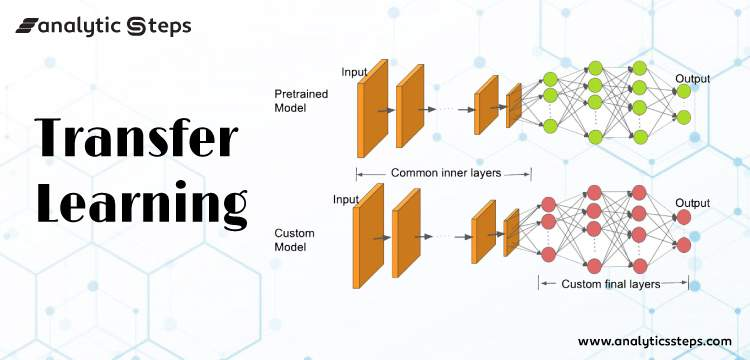

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

### ***Downloading & Loading the dataset***

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:07<00:00, 141MB/s]
100% 1.06G/1.06G [00:07<00:00, 162MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### ***Import Necessary Libraries***

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

### ***Defining the Convolutional Base & Freezing it & discarding the top layer (Dense Layer to train again)***

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

From the model.summary(), it can be easilty insighted that we're only proceeding with the convolutional layer(conv_base) only. 

<br>


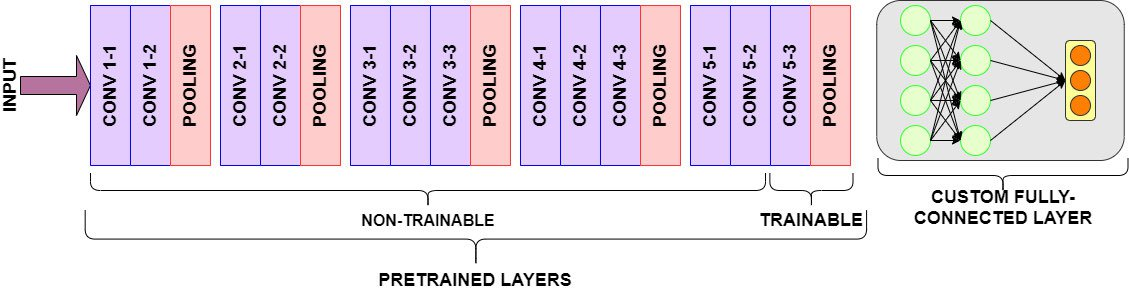


**If we notice that the last block is the block5 ending with the maxpooling layer for block5**:
<br><br>
**block5_conv1 (Conv2D)       (None, 9, 9, 512)         2359808**  
                                                                 
 **block5_conv2 (Conv2D)       (None, 9, 9, 512)         2359808**   
                                                                 
 **block5_conv3 (Conv2D)       (None, 9, 9, 512)         2359808**   
                                                                 
 **block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0**         
                                                                 

### ***Defining the sequential model & adding the conv_base***

In [ ]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


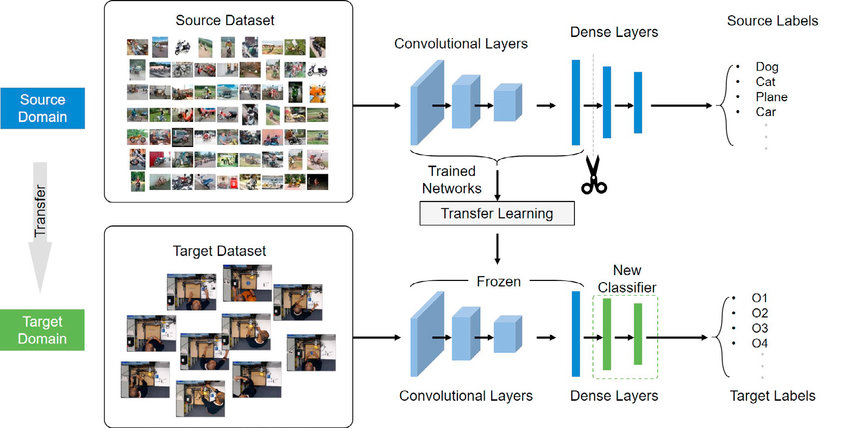

Here it can be noticed that the Trainable Parameters have been reduced to **`2,097,665`** from **`16,812,353`** (After adding the **`dense layer (2,097,665) to the conv_base (14,714,688)`**).

So, this in turn prevents the training of basic features again rather to focus on the classification part to focus on, to give proper output.

In [ ]:
conv_base.trainable = False

### ***Defining Training & Validation set for model training***

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


### ***Normalizing the dataset for smooth training***

In [ ]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

### ***Model Training***

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 78s 105ms/step - loss: 0.2631 - accuracy: 0.8891 - val_loss: 0.2011 - val_accuracy: 0.9150
Epoch 2/10
625/625 [==============================] - 66s 106ms/step - loss: 0.1949 - accuracy: 0.9181 - val_loss: 0.1935 - val_accuracy: 0.9186
Epoch 3/10
625/625 [==============================] - 66s 106ms/step - loss: 0.1594 - accuracy: 0.9322 - val_loss: 0.2044 - val_accuracy: 0.9152
Epoch 4/10
625/625 [==============================] - 67s 107ms/step - loss: 0.1265 - accuracy: 0.9487 - val_loss: 0.2370 - val_accuracy: 0.9080
Epoch 5/10
625/625 [==============================] - 67s 107ms/step - loss: 0.1049 - accuracy: 0.9593 - val_loss: 0.2344 - val_accuracy: 0.9128
Epoch 6/10
625/625 [==============================] - 67s 107ms/step - loss: 0.0798 - accuracy: 0.9700 - val_loss: 0.2662 - val_accuracy: 0.9036
Epoch 7/10
625/625 [==============================] - 66s 105ms/step - loss: 0.0593 - accuracy: 0.9781 - val_loss: 0.2895 - val_ac

### ***Loss curve for Accuracy***

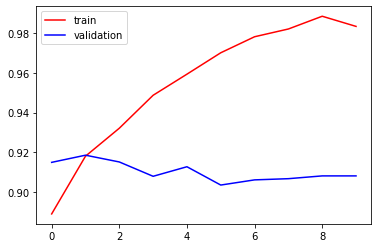

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

We can see that there is a huge gap between the train & validation curve, indicating the model overfitting.

**Epoch 10/10 <br>
625/625 [==============================] - 66s 105ms/step - loss: 0.0438 - accuracy: 0.9833 - val_loss: 0.3412 - val_accuracy: 0.9082**

Just check the accuracy & val_accuracy change, which can be easily be seen in the loss graph as well.<br>
This can be improved by optimizing the parameters or by increasing the no. of epochs or most importantly by using **Data Augmentation**.

### ***Loss curve for training loss***

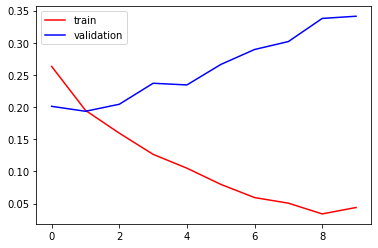

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

**Epoch 10/10 <br>
625/625 [==============================] - 66s 105ms/step - loss: 0.0438 - accuracy: 0.9833 - val_loss: 0.3412 - val_accuracy: 0.9082**

Check the val_loss & the loss values, the gap shows how the model is overfitted.

**Name:** Shobhandeb Paul  <br>
**Linkedin:** https://www.linkedin.com/in/shobhandeb-paul/ <br>
**Github:** https://github.com/herbert0419 